# Import the relevant libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
!git clone https://github.com/cardstdani/WasteClassificationNeuralNetwork.git

Cloning into 'Waste_Classification_using_ResNet152'...
remote: Enumerating objects: 5107, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 5107 (delta 20), reused 43 (delta 20), pack-reused 5064
Receiving objects: 100% (5107/5107), 197.01 MiB | 22.04 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (5084/5084), done.


# Import the dataset

### Split the Dataset into training and testing

In [ ]:
DIR = "/content/WasteClassificationNeuralNetwork/WasteImagesDataset"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1,
                                                                    subset="training", seed=42,
                                                                    batch_size=16, smart_resize=True)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1,
                                                                  subset="validation", seed=42,
                                                                  batch_size=16, smart_resize=True)

Found 5078 files belonging to 9 classes.
Using 4571 files for training.
Found 5078 files belonging to 9 classes.
Using 507 files for validation.


### Optimise the training and testing performance

In [ ]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes, numClasses)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood'] 9


### Performing Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

### Resnet152 Model

In [ ]:
baseModel = tf.keras.applications.ResNet152(input_shape=(256, 256, 3), weights='imagenet',
                                           include_top=False, classes=numClasses)

for layers in baseModel.layers:
    layers.trainable=False

last_output = baseModel.layers[-1].output

x = tf.keras.layers.Dropout(0.5)(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=10
callbacks = tf.keras.callbacks.EarlyStopping(patience=2)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[callbacks])

234698864/234698864 [==============================] - 2s 0us/step
Epoch 1/10
286/286 [==============================] - 2910s 10s/step - loss: 0.8470 - accuracy: 0.7580 - val_loss: 0.4739 - val_accuracy: 0.8442
Epoch 2/10
286/286 [==============================] - 2928s 10s/step - loss: 0.1366 - accuracy: 0.9593 - val_loss: 0.4199 - val_accuracy: 0.8797
Epoch 3/10
286/286 [==============================] - 2865s 10s/step - loss: 0.0614 - accuracy: 0.9812 - val_loss: 0.3716 - val_accuracy: 0.8836
Epoch 4/10
286/286 [==============================] - 2896s 10s/step - loss: 0.0406 - accuracy: 0.9884 - val_loss: 0.4859 - val_accuracy: 0.8994
Epoch 5/10
286/286 [==============================] - 2848s 10s/step - loss: 0.0191 - accuracy: 0.9950 - val_loss: 0.5529 - val_accuracy: 0.8856


In [ ]:
model.save("/content/model.h5")
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

To create predictions over a single image, which is the primary use of this model, we may transform the input image to an array of values using the Keras API and then use the predict() method to receive predictions from the model.

# Testing

1/1 [==============================] - 1s 535ms/step
[1.7588022e-08 1.1763850e-07 5.5464482e-09 9.8160698e+01 7.8548243e-07
 1.7498133e+00 5.0720409e-05 7.3279321e-02 1.6176183e-02] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Prediction:  Organic Waste 98.16069602966309%


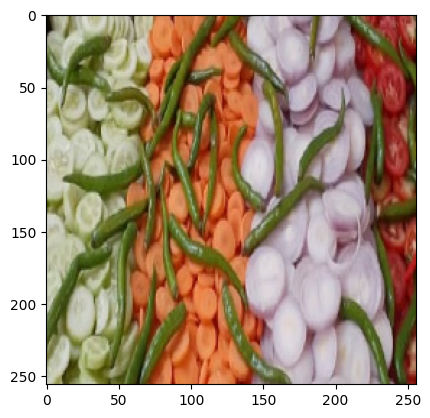

In [ ]:

image = "/content/WhatsApp Image 2024-02-05 at 11.48.37_831034fa.jpg"

img = tf.keras.preprocessing.image.load_img(image, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

[2.3111986e-02 7.1516033e-04 1.8855692e-01 2.4329787e-03 9.9353493e+01
 3.1102604e-01 1.0386837e-01 1.6348640e-02 4.4064136e-04] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Prediction:  Other Plastics 99.35349225997925%


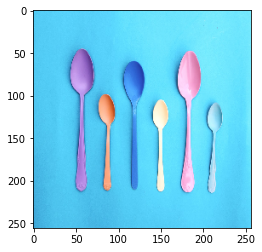

In [ ]:
import requests

img_data = requests.get("httpsdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1064&q=80").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

We can see the final results by creating a Confusion Matrix and assessing the model using data from both datasets. The acquired accuracy is 98 percent, however the overfitting problem discussed previously might reduce this number to 97 percent or even 96 percent. Nonetheless, the best approach to assess the model's performance is to deploy it to production and evaluate it with a huge amount of 'unseen' data.

# Confusion Matrix

<Figure size 720x720 with 0 Axes>

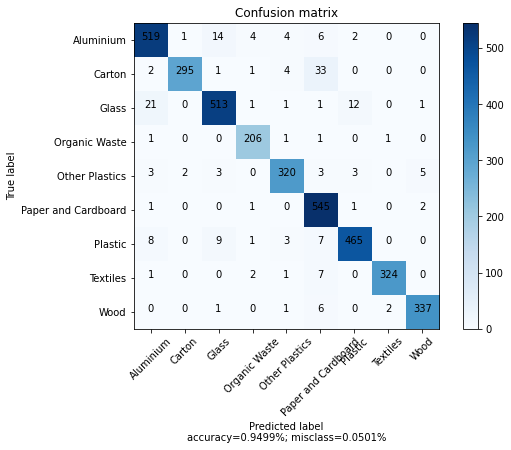

In [ ]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []


path = "WasteImagesDataset/"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)